In [33]:
import imageio
import numpy as np
from new_functions import *
from PIL import Image

from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
% matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
# # Read Some Images
# X, Y, Joints, Hand_Info = read_img_data2(50)

In [95]:
# # Display an image
# plt.imshow(X[0].astype(np.uint8))

In [96]:
# # Print some Y's and J's. J = 0 means left hand, J = 1 means right hand.
# # Y = 1 means hand is present in the image.
# print(Y[:10])
# print(Hand_Info[:10])

In [97]:
# X[4].shape

In [98]:
# labels = gen_labels2(Y, Joints)

In [99]:
# np.argwhere(labels[4] == 1)


In [100]:
# _, cx, cy, h, w = labels[4][1][1]


In [123]:
# convert cx, cy back to consider the full image  #Need grid position! 1 -> x_grid = 1, same for y
cx = (1+cx)/3
cy = (1+cy)/3
print(cx, cy, h , w)

0.5594229166666665 0.4293481481481481 0.05566249999999995 0.12019259259259257


In [122]:
# _, cx, cy, h, w = labels[1][1][1]
# print(cx, cy, h , w)

0.6782687499999998 0.2880444444444443 0.05566249999999995 0.12019259259259257


In [101]:
# #Joints[4]
# import Tkinter

# PyTorch    (YOLO?)

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import timeit

In [35]:
dtype = torch.FloatTensor # the CPU datatype

# Constant to control how frequently we print train loss
print_every = 100

# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

# make 50 -> 1000 or more 

In [36]:
X, Y, Joints, Hand_Info = read_img_data2(50)

In [37]:
Y_train = gen_labels2(Y, Joints, grid_size=3)
Y_rolled = np.rollaxis(Y_train, 3, 1)
print('Y_rolled shape: ', Y_rolled.shape)
X_rolled = to_channels_first2(X)
# Y_rolled = to_channels_first(Y_train)
print('X_rolled shape: ', X_rolled.shape)
# print('Y_rolled shape: ', Y_rolled.shape)

Y_rolled shape:  (50, 5, 3, 3)
X_rolled shape:  (50, 3, 100, 100)


In [38]:
Y_train = torch.from_numpy(Y_rolled)
Y_train = Y_train.type(dtype)
X_train = torch.from_numpy(X_rolled).type(dtype)
print(X_train.size())
print(Y_train.size())

torch.Size([50, 3, 100, 100])
torch.Size([50, 5, 3, 3])


In [39]:
#Y = Y.reshape(Y.shape[0], 1,1,1)

In [40]:
Y_train.shape

torch.Size([50, 5, 3, 3])

In [41]:
# Y = torch.from_numpy(Y)
# Y=Y.type(dtype)
# Y.type

In [73]:
# print(Y_train[:,:])
# plt.imshow(X[10])

In [122]:
# def train(X, Y, model, loss_fn, optimizer, batch_size=10, num_epochs=1):
#     for epoch in range(num_epochs):
#         print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
# #         model.train()
#         # X_batch, Y_batch = ...
#         x_var = Variable(X.type(dtype))
#         y_var = Variable(Y.type(dtype))

#         scores = model(x_var)

#         loss = loss_fn(scores, y_var)
# #         if (t + 1) % print_every == 0:
# #             print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         print('loss: ', loss)

In [42]:
fixed_model_base = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=5, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(64, 64, kernel_size=5, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    
        nn.Conv2d(64, 64, kernel_size=3, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(),
        nn.Conv2d(64, 32, kernel_size=3, stride=1),
        #nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(),
        nn.Conv2d(32, 5, kernel_size=2, stride=1),
        nn.ReLU(inplace=True),
        nn.Dropout2d(),
#         nn.Conv2d(16, 7, kernel_size=3, stride=1),
#         nn.ReLU(inplace=True),
        #nn.LogSigmoid(),
        #nn.Linear(1,1)
        nn.Softmax()
    )

fixed_model = fixed_model_base.type(dtype)



In [43]:
import math

In [76]:
math.sqrt(25)

5.0

# Can Vary the +1 under the if statement upto +5

In [44]:
def yolo_loss(Output, Y_train):
    sum1 = 0
    count = 0
    for out , label in (zip(Output, Y_train)):
        for i in range(3):
            for j in range(3):
                c_hat = iou([Y_train[count][1][i][j] - (Y_train[count][3][i][j])/2, Y_train[count][2][i][j] + (Y_train[count][4][i][j]/2),Y_train[count][1][i][j] + (Y_train[count][3][i][j])/2, Y_train[count][2][i][j] - (Y_train[count][4][i][j]/2)],
                              [Output[count][1][i][j] - (Output[count][3][i][j])/2, Output[count][2][i][j] + (Output[count][4][i][j]/2),Output[count][1][i][j] + (Output[count][3][i][j])/2, Output[count][2][i][j] - (Output[count][4][i][j]/2)] )
                #print(c_hat)
                if Y_train[count][0][i][j] == 1:
                    sum1 += 1 * ((Y_train[count][1][i][j]- Output[count][1][i][j])**2 + (Y_train[count][2][i][j]- Output[count][2][i][j])**2)
                    sum1 += 1 * ((math.sqrt(Y_train[count][3][i][j])- math.sqrt(Output[count][3][i][j]))**2 + (math.sqrt(Y_train[count][4][i][j])- math.sqrt(Output[count][4][i][j]))**2)
                    #sum1 += 5 * ((math.sqrt(Y_train[count][3][i][j])- math.sqrt(Output[count][3][i][j]))**2 + (math.sqrt(Y_train[count][4][i][j])- math.sqrt(Output[count][4][i][j]))**2)
                    #sum1 += (Y_train[count][0][i][j] -c_hat)**2
                    sum1 += (Y_train[count][0][i][j] - Output[count][0][i][j])**2
                    
                else:
                    sum1 += 0.5*(Y_train[count][0][i][j] -c_hat)**2
        count +=1
    return sum1

        
    

# Chage learning rate

In [74]:
#loss_fn = yolo_loss().type(dtype)
loss_fn = nn.MSELoss().type(dtype)
#loss_fn = nn.L1Loss().type(dtype)
optimizer = optim.RMSprop(fixed_model.parameters(), lr= 1e-4)
#loss_fn = nn.CrossEntropyLoss().type(dtype)
## Now we're going to feed a random batch into the model you defined and make sure the output is the right size
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

fixed_model.apply(init_weights)
# in your training loop:
it = 50
optimizer.zero_grad()   # zero the gradient buffers
fixed_model.train()
c = 0.0002
#Y_train_ = Y_train.type(torch.LongTensor)
for iter in range(it):
    output = fixed_model(X_train)
    loss = yolo_loss(output, Y_train)
    #loss = loss_fn(output, Y_train)
    optimizer.zero_grad()
    loss.backward()
#     for param_group in optimizer.param_groups:
#         param_group['lr'] -=c
    optimizer.step()    # Does the update
    
    print('loss :' , loss.item())

C:\Users\zarin\Anaconda3\lib\site-packages\torch\nn\modules\container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss : 15.197607040405273
loss : 17.008121490478516
loss : 19.963184356689453
loss : 17.586444854736328
loss : 18.465036392211914
loss : 16.77046012878418
loss : 17.623497009277344
loss : 17.095022201538086
loss : 17.377470016479492
loss : 20.788541793823242
loss : 17.918703079223633
loss : 17.715299606323242
loss : 20.710670471191406
loss : 16.314252853393555
loss : 17.152774810791016
loss : 17.837265014648438
loss : 16.556201934814453
loss : 16.678577423095703
loss : 17.841007232666016
loss : 17.083667755126953
loss : 17.367700576782227
loss : 17.259492874145508
loss : 18.386844635009766
loss : 15.074274063110352
loss : 16.042442321777344
loss : 18.815214157104492
loss : 16.469247817993164
loss : 13.119872093200684
loss : 16.561710357666016
loss : 16.25469398498535
loss : 16.849225997924805
loss : 17.826557159423828
loss : 14.99821949005127
loss : 17.367372512817383
loss : 16.327096939086914
loss : 14.907376289367676
loss : 15.877387046813965
loss : 16.797657012939453
loss : 15.59896

In [75]:
preds = fixed_model(X_train)

C:\Users\zarin\Anaconda3\lib\site-packages\torch\nn\modules\container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [79]:

preds2 = preds

In [73]:
Y_train[:10]

tensor([[[[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  1.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.6867,  0.0000],
          [ 0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.2806,  0.0000],
          [ 0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0651,  0.0000],
          [ 0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.1222,  0.0000],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  1.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.6783,  0.0000],
          [ 0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.2880,  0.0000],
          [ 0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000],
       

# Here I make prediction>= 0.5 to be one and <0.5 to be 0
    

In [107]:
count = 0
success = 0
failure = 0
for item in preds2:
    if item[0][1][1]>=0.5:
        if count< 25:
            item[0][1][1] = 1
            success+=1
            
        else:
            item[0][1][1] = 1
            failure +=1
        
    elif item[0][1][1]<0.5:
        if count>=25:
            item[0][1][1] = 0
            success += 1
        else:
            item[0][1][1] = 0
            failure +=1
    else:
        print("nan")
    count+=1
print(success, "success")
print(failure, "failure")

35 success
15 failure


# can you use preds2 and the images to draw bounding box? But also make sure that you take into account that the x,y are w.r.t each grid and w,h are with respect to the the image.


# CRAP BELOW


In [118]:
preds.shape
new = preds
new =new.detach().numpy()


In [120]:
new = new.reshape(new.shape[0],)

In [121]:
new

array([0.01135982, 0.87692744, 0.6167153 , 0.5396809 , 0.01177701,
       0.01216818, 0.1118563 , 0.87692744, 0.755402  , 0.87692744,
       0.03742406, 0.87692744, 0.66704714, 0.87692744, 0.7314897 ,
       0.0214721 , 0.87692744, 0.87692744, 0.87692744, 0.5817198 ,
       0.87692744, 0.87692744, 0.43635008, 0.03580783, 0.87692744,
       0.87692744, 0.80255103, 0.87692744, 0.87692744, 0.01138497,
       0.01135982, 0.02130419, 0.0114847 , 0.87692744, 0.87692744,
       0.01241615, 0.87692744, 0.01145151, 0.87692744, 0.01138929,
       0.01158636, 0.01149289, 0.87692744, 0.06400666, 0.02028817,
       0.2257802 , 0.87692744, 0.87692744, 0.87692744, 0.04292852],
      dtype=float32)

In [122]:
Yn = Y.reshape(Y.shape[0],)
Yn

tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.])

In [124]:
Yn = Yn.detach().numpy()
Yn.shape


(50,)

In [127]:
Yn.shape[0]

50

In [135]:
count = 0
w = 0
for i in range(Yn.shape[0]):
    if new[i]>0.5:
        if Yn[i] ==1:
            count +=1
        else:
            w+=1
    else:
        if Yn[i] ==1:
            w+=1
        else:
            count+=1
print(count, w)
            

30 20


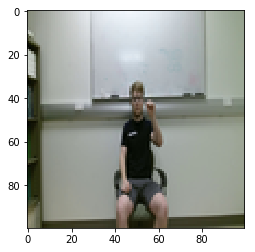

In [359]:
plt.imshow(X[4].astype('uint8'))

In [106]:
# l = 0.
# l = l + (output[0][:5,1,1] - Y_train[0][:5,1,1]).sum()**2
# l

In [105]:
# l = 0.
# l = l + (output[0][0,1,1] - Y_train[0][0,1,1])**2
# l

In [104]:
# loss_fn = nn.MSELoss().type(dtype)
# print(output[0][:][0][0])
# print(Y_train[0][:][0][0])
# print(Y_train[0][0])
# print(Y_train[0][:5,1,1])
# print(output[0][:5,1,1])
# loss_fn(output[0][:5,1,1], Y_train[0][:5,1,1])

In [102]:
# (output[0][:5,1,1] - Y_train[0][:5,1,1])

In [103]:
# ((output[0][:5,1,1] - Y_train[0][:5,1,1])**2).sum()

In [127]:
#train(X_train, Y, fixed_model, loss_fn, optimizer, num_epochs=10)

In [126]:
#train(fixed_model, loss_fn, optimizer)

In [30]:
x = open('C:/Users/zarin\Desktop/b/c/d.txt')

In [31]:
# for i in x:
#     print(i)

asdcaFC
